In [1]:
import pystan
import arviz as az
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import scipy.stats as stats
import seaborn as sns
import pandas as pd

<h1>Part 1:</h1>
<h3>Gamma distributions</h3>

I've generated 3 instances of gamma distribution, each with different scale and shape parameters:

In [2]:
gammas = {
    "gamma1":np.random.gamma(scale=5,shape=5,size=5000),
    "gamma2":np.random.gamma(scale=5,shape=10,size=5000),
    "gamma3":np.random.gamma(scale=10,shape=5,size=5000),
}

I've converted the dictionary to pandas dataframe, melted it and created seaborn facetgrid to plot the histograms:

In [3]:
df = pd.DataFrame.from_dict(gammas)
df_melted = pd.melt(df, var_name='variant', value_name='value')

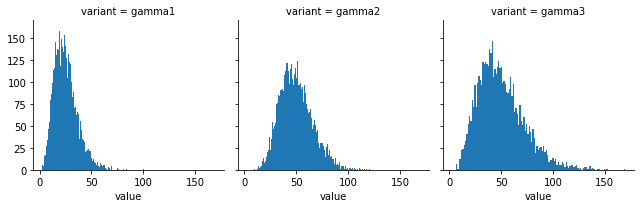

In [4]:
g = sns.FacetGrid(df_melted, col="variant", sharex=True, sharey=True)
g.map(plt.hist, "value", cumulative=False, bins=128)

Histograms allowed me to draw some conclusions: The scale parameter scales stretches the distribution, so that occurence of higher values is noticed. The shape parameter influences the steepness of the distribution.

I've generated 3 instances of inverse gamma distribution, each with different scale and shape parameters:

In [5]:
inv_gammas = {
    "invgamma1":stats.invgamma.rvs(a=5,scale=5,size=5000),
    "invgamma2":stats.invgamma.rvs(a=5,scale=10,size=5000),
    "invgamma3":stats.invgamma.rvs(a=10,scale=5,size=5000)
}

In [6]:
df_inv = pd.DataFrame.from_dict(inv_gammas)
df_inv_melt = pd.melt(df_inv, var_name='variant', value_name='value')

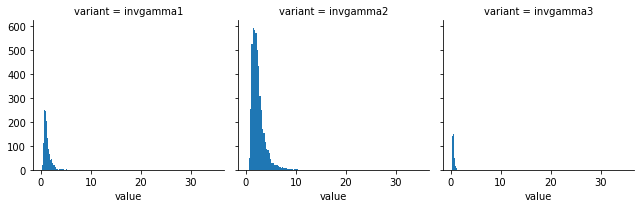

In [7]:
g = sns.FacetGrid(df_inv_melt, col="variant", sharex=True, sharey=True)
g.map(plt.hist, "value", cumulative=False, bins=128)

<h4>Conclusions:</h4>

The a parameter (shape) influences the distribution similarly to the way the shape parameter influences histogram in gamma distribution - the higher a parameter is, the broader and less steep the histogram is.

As for scale parameter, it influences the height of the histogram, but also its width - similarly as in gamma distribution. The higher the scale, the smaller distribution (shape is similar).

<h4>Gamma distribution with Stan </h4>
The task of finding parameters for gamma distribution, for which 98% probability lies between 5 and 10 needed a predefined stan file, which is included in the repository as well. I used the algebra_solver.

In [8]:
with open('gamma.stan','r') as file:
    print(file.read())

functions {
  vector tail_delta(vector y, vector theta, real[] x_r, int[] x_i) {
    vector[2] deltas;
    deltas[1] = gamma_cdf(theta[1], y[1], y[2]) - 0.01;
    deltas[2] = gamma_cdf(theta[2], y[1], y[2]) - 0.99;
    return deltas;
  }
}
data {
  vector<lower=0>[2] y_guess;
  vector<lower=0>[2] theta;
}
transformed data {
  vector[2] y;
  real x_r[0];
  int x_i[0];
  y = algebra_solver(tail_delta, y_guess, theta, x_r, x_i,1e-10,1e-1,1e6);
}
generated quantities {
  real alpha = y[1];
  real beta = y[2];
}


I've complited the model using stan:

In [9]:
model = pystan.StanModel('gamma.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_46207c379a6b7bdb88777cc967fe21b7 NOW.


I've decided to start the model with alpha = 5 and beta = 1. The important thing is that theta interval is <5,10>. It provides assurance, that 98% (due to stan file) of ditribution will be placed in this interval.

In [10]:
data = dict(y_guess=np.array([5,1]),theta=np.array([5,10]))
tuned_data = model.sampling(data=data, seed=1052020, algorithm="Fixed_param",iter=1,chains=1)

alpha = np.round(tuned_data.extract()['alpha'][0])
beta = np.round(tuned_data.extract()['beta'][0])

print('Alpha:\t'+str(alpha)+'\nBeta:\t'+str(beta))

Alpha:	46.0
Beta:	6.0


To check the result, I've drawn the histogram using these two as parameters:

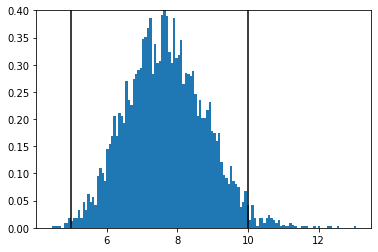

In [11]:
gamma_result = np.random.gamma(shape=alpha, scale=1/beta,size=5000)
plt.hist(gamma_result, bins = 128, density=True)
plt.plot([5,5],[0,0.4],color='black')
plt.plot([10,10],[0,0.4],color='black')
plt.ylim([0,0.4])
plt.show()

The histogram look as expected. Around 90% of distrubution is between 5 and 10.

<h4>Inv Gamma distribution with Stan</h4>

I've done the same example with inv gamma distribution, to see, if stan model again proves useful. 98% percent of dist. must be contained in <5,10>.

I've created following stan file:

In [12]:
with open('inv_gamma.stan','r') as file:
    print(file.read())

functions {
  vector tail_delta(vector y, vector theta, real[] x_r, int[] x_i) {
    vector[2] deltas;
    deltas[1] = inv_gamma_cdf(theta[1], y[1], y[2]) - 0.01;
    deltas[2] = inv_gamma_cdf(theta[2], y[1], y[2]) - 0.99;
    return deltas;
  }
}
data {
  vector<lower=0>[2] y_guess;
  vector<lower=0>[2] theta;
}
transformed data {
  vector[2] y;
  real x_r[0];
  int x_i[0];
  y = algebra_solver(tail_delta, y_guess, theta, x_r, x_i,1e-10,1e-1,1e6);
}
generated quantities {
  real alpha = y[1];
  real beta = y[2];
}


In [13]:
model = pystan.StanModel('inv_gamma.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_9b490040c27276226da8ab310175f4cc NOW.


In [14]:
data = dict(y_guess=np.array([0.5,0.4]),theta=np.array([5,10]))
tuned_data = model.sampling(data=data, seed=1052020, algorithm="Fixed_param",iter=1,chains=1)

alpha = np.round(tuned_data.extract()['alpha'][0])
beta = np.round(tuned_data.extract()['beta'][0])

print('Alpha:\t'+str(alpha)+'\nBeta:\t'+str(beta))

Alpha:	62.0
Beta:	399.0


Once again, I've drawn histogram to see, if the result is correct.

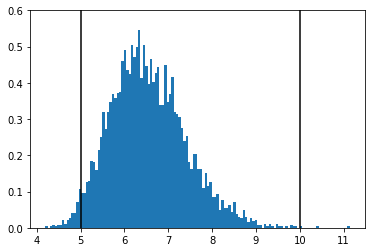

In [15]:
inv_gamma_result = stats.invgamma.rvs(a=alpha, scale=beta,size=5000)
plt.hist(inv_gamma_result, bins = 128, density=True)
plt.plot([5,5],[0,0.6],color='black')
plt.plot([10,10],[0,0.6],color='black')
plt.ylim([0,0.6])
plt.show()

It looks, that the result is one again correct. It's safe to assume, that 98% of the distribution is between 5 and 10.

<h1>Part 2:</h1>
<h3>Negative binomial distribution</h3>

I used one stan file to generate only one model containing all three required distributions:
* negative binomial distribution;
* negative binomial distribution with alternate params;
* poisson distribution with tje same mean;

In [16]:
with open('negative_binomial.stan','r') as file:
    print(file.read())

data {
  real<lower=0> alpha;
  real<lower=0> beta;
  real<lower=0> micro;
  real<lower=0> phi;
  real<lower=0> lam;
}

generated quantities {
  int<lower=0> y1;
  int<lower=0> y2;
  int<lower=0> y3;
  y1 = neg_binomial_rng(alpha,beta);
  y2 = neg_binomial_2_rng(micro,phi);
  y3 = poisson_rng(lam);
}


In [17]:
model = pystan.StanModel('negative_binomial.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_3a8a7da7275019368437ff6252867c61 NOW.


In [18]:
data = dict(alpha=5,beta=1,micro=5,phi=5,lam=5)

data_tuned = model.sampling(data=data, seed=1052020, algorithm="Fixed_param",iter=500)

y1 = data_tuned.extract()['y1']
y2 = data_tuned.extract()['y2']
y3 = data_tuned.extract()['y3']

mean_y1 = np.mean(y1)
mean_y2 = np.mean(y2)
mean_y3 = np.mean(y3)

print("Mean values:")
print("Binomial dist.:\t\t\t"+str(mean_y1))
print("Binomial dist.(alternative):\t"+str(mean_y2))
print("Poisson dist.:\t\t\t"+str(mean_y3))

Mean values:
Binomial dist.:			4.919
Binomial dist.(alternative):	5.032
Poisson dist.:			5.041


All the mean are very similar. What could be disturbing, is that alternative parametrisation provides mean closer to tje Poisson dist., not to the negative binomial one.

I've plotted all the distributions on one histogram, visible below, to see the shape of each one:

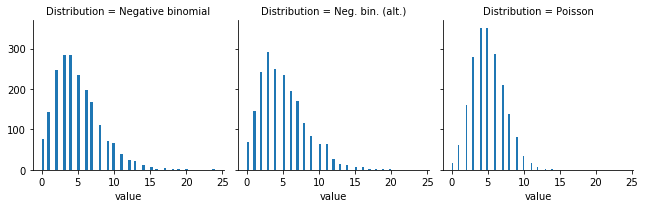

In [19]:
y = pd.DataFrame(data={"Negative binomial":y1,"Neg. bin. (alt.)":y2,"Poisson":y3})
y = pd.melt(y,var_name='Distribution',value_name='value')

g = sns.FacetGrid(y,col='Distribution',sharex=True,sharey=True)
g.map(plt.hist,'value',cumulative=False,bins=64)

Drawing those histograms was quite useful. Now we can see, that even though Poisson and 2nd variant of neg. bin. distributions have closer means, their shapes are quite different, and so, both negative binomial distributions are very close, when it comes to their shape.

<h1>Part 3:</h1>
<h3>Student-t distribution</h3>

The stan file I've created to get the Stan model running is presemted below:

In [20]:
with open('student_t.stan','r') as file:
    print(file.read())

data {
  int<lower=0> num;
  real<lower=0> NU;
  real MU[num];
  real<lower=0> sigma[num];
}

parameters {
  real y[num];
}

model {
  y ~ student_t(NU,MU,sigma);
}


In [21]:
model = pystan.StanModel('student_t.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_8c868da2c44a40f2d48fd1b6e23b8769 NOW.


I've created four different variants of parameters to check on the histograms, which are attached below, along with the usage of previously creatd Stan model.

The values are:
    * NU = 2; MU = 0; sigma = 1;
    * NU = 2; MU = 0; sigma = 5;
    * NU = 2; MU = 5; sigma = 1;
    * NU = 2; MU = 5; sigma = 5;

In [22]:
num = 4;
nu = 2;
mu = np.array([0,0,5,5])
sigma = np.array([1,5,1,5])

data=dict(num=num, NU=nu, MU=mu, sigma=sigma)

data_tuned = model.sampling(data=data, seed=1052020, iter=1000,chains=1)

y = data_tuned.extract()['y']

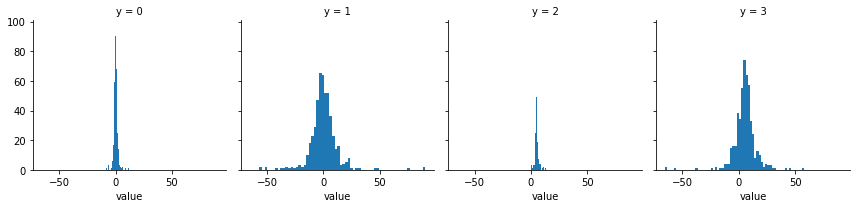

In [23]:
y = pd.DataFrame(y)
y = pd.melt(y, var_name='y',value_name='value')

g = sns.FacetGrid(y,col='y',sharex=True,sharey=True)
g.map(plt.hist,'value',bins=64)
plt.show()

The sigma value changes the shape of the distribution - the higher the sigma, the wider distribution is.

Then, I've checked how number of iterations influences the distribution:

In [24]:
model = pystan.StanModel('student_t_2.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_520c0367c1658eb642b5c8429c48368d NOW.


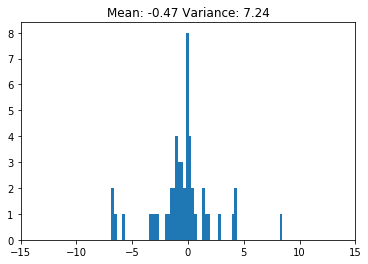

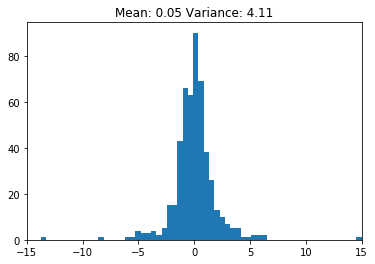

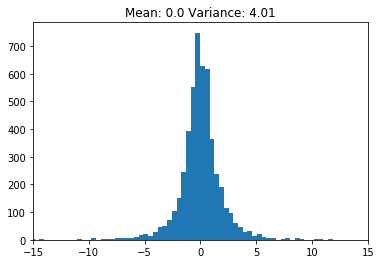

In [25]:
iterations = [100,1000,10000]
data = dict(NU=2, MU=0, sigma=1)

for i in iterations:
    data_tuned = model.sampling(data=data,iter=i,chains=1,seed=1052020)
    y = data_tuned.extract()['y']
    plt.figure()
    plt.hist(y, bins=64)
    mean = np.round(np.mean(y),2)
    variance = np.round(np.var(y),2)
    plt.title("Mean: "+ str(mean) + " Variance: " + str(variance))
    plt.xlim(-15,15)

100 iterations wasn't enough to get correct values and the correct shape of histogram.
1000 iterations is ok, but only with aproximation.
10000 iterations result is not much better result as it takes 10 times more iterations.

I've used student-t distrubution with specific set of parameters to get Cauchy distribution:

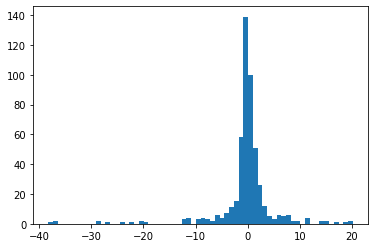

In [26]:
data = dict(NU=1,MU=0,sigma=1)
data_tuned = model.sampling(data=data,iter=1000,chains=1,seed=1052020)

y = data_tuned.extract()['y']
plt.hist(y,bins=64)
plt.show()

<h1>Part 4:</h1>
<h3>Multirative normal distributions</h3>

I've used the stan file presented below to generate model and get all neccessary histograms:

In [27]:
with open('multirative_normal.stan') as file:
    print(file.read())

data {
  int<lower=0> dim;
  vector[dim] MU;
  matrix[dim,dim] sigma;
}

parameters {
  vector[dim] y;
}

model {
  y ~ multi_normal(MU,sigma);
}


In [28]:
model = pystan.StanModel('multirative_normal.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_eb222ba08cf5c8a18dd250b1dded7fd3 NOW.


I've created function, that allow me to get the covariance from correltion matrix and the other way:

In [29]:
def cov2cor(cov):
    v = np.sqrt(np.diag(cov))
    v_outer = np.outer(v,v)
    cor = cov/v_outer
    cor[cov==0]=0
    return cor

def cor2cov(cor,std_dev):
    std_dev_outer = np.outer(std_dev,std_dev)
    cov = std_dev_outer*cor
    return cov

I've used them to generate random input data for model, to observe it's behaviour:

In [30]:
cor_matrix = [(1,0.7),(0.7,1)]
std_dev = [1,7]
cov_matrix = cor2cov(cor_matrix,std_dev)
print(cov_matrix)

[[ 1.   4.9]
 [ 4.9 49. ]]


In [31]:
data = dict(dim=2, MU=[0, 7], sigma=cov_matrix)
data_tuned = model.sampling(data=data, iter=5000,seed=1052020)

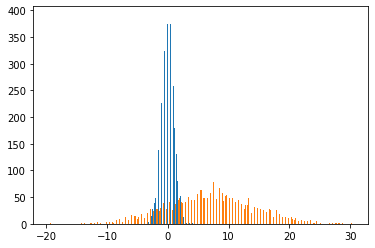

In [32]:
y = data_tuned.extract()['y']
plt.hist(y, bins=512)
plt.show()

In 2D it looks like this:

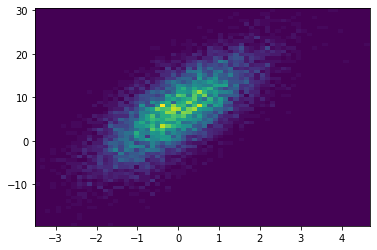

In [33]:
plt.hist2d(y[:,0],y[:,1],bins=64)
plt.show()

To do the same in 3D, I needed to change the model and it's parameters as below:

In [34]:
cor_matrix = [(1,0.7,0.7),(0.7,1,0.7),(0.7,0.7,1)]
std_dev = [1,4,7]
cov_matrix = cor2cov(cor_matrix,std_dev)

In [35]:
data = dict(dim=3, MU=[0,3,7], sigma=cov_matrix)
data_tuned = model.sampling(data=data, iter=5000,seed=1052020)

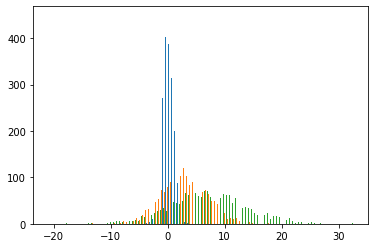

In [36]:
y = data_tuned.extract()['y']
plt.hist(y, bins=512)
plt.show()

And, finally, 4D analisys:

In [37]:
cor_matrix = [(1,0.7,0.7,0.7),(0.7,1,0.7,0.7),(0.7,0.7,1,0.7),(0.7,0.7,0.7,1)]
std_dev = [1,2,5,7]
cov_matrix = cor2cov(cor_matrix,std_dev)

In [38]:
data = dict(dim=4, MU=[0,2,5,7], sigma=cov_matrix)
data_tuned = model.sampling(data=data, iter=5000,seed=1052020)

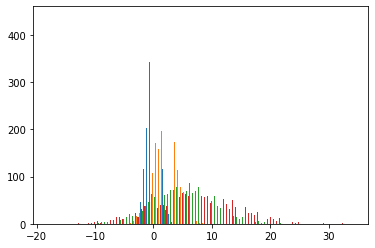

In [39]:
y = data_tuned.extract()['y']
plt.hist(y, bins=512)
plt.show()

<h2>Conclusions:</h2>

Stan allows to generate multiple models for various distribution types. Immensity of parameters gives an oppourtunity to customize these distributions dependently of its type. '.stan' files use simple structure to generate models from practically text files.